In this tutorial we would like to investigate the impact of changing the various parameters related to a neural network on its performance (both accuracy and runtime).

In particular, we would like to investigate the impact of early stopping criterion, weight decay and momentum. We will also be using cross validation methods to obtain results on its performance.

We will utilise the skorch library to help us in our investigation. The skorch library allows us to wrap any neural network in a data pipeline, and then allows us to easily set its various parameters (such as the ones mentioned above). In addition the skorch library contain functions that makes it easy to use methods from the sklearn library such as cross validation.

The first part of this tutorial focuses on obtaining and perparing the MNIST library, which we will utilise for the experiments in the rest of this tutorial.

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

## Loading Data
Using SciKit-Learns ```fetch_openml``` to load MNIST data.

In [3]:
mnist = fetch_openml('mnist_784', cache=False)

In [4]:
mnist.data.shape

(70000, 784)

## Preprocessing Data

Each image of the MNIST dataset is encoded in a 784 dimensional vector, representing a 28 x 28 pixel image. Each pixel has a value between 0 and 255, corresponding to the grey-value of a pixel.<br />
The above ```featch_mldata``` method to load MNIST returns ```data``` and ```target``` as ```uint8``` which we convert to ```float32``` and ```int64``` respectively.

In [5]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

To avoid big weights that deal with the pixel values from between [0, 255], we scale `X` down. A commonly used range is [0, 1].

In [6]:
X /= 255.0
# Convert pandas dataframe to numpy array
X = X.to_numpy()

In [7]:
X.min(), X.max()

(0.0, 1.0)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

NameError: name 'train_test_split' is not defined

In [10]:
X_train.shape, y_train.shape

((52500, 784), (52500,))

### Print a selection of training images and their labels

In [1]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

In [2]:
plot_example(X_train, y_train)

NameError: name 'X_train' is not defined

## Building the base neural network

In this section we will specify the structure of our neural network which we will use for the rest of our analysis.

It will be a fully connected neural network with one hidden layer. Input layer has 784 dimensions (28x28), hidden layer has 98 (= 784 / 8) and output layer 10 neurons, representing digits 0 - 9.

In [13]:
import torch
from torch import nn
import torch.nn.functional as F
device = 'cpu'

In [26]:
mnist_dim = X.shape[1]
hidden_dim = int(mnist_dim/8)
output_dim = len(np.unique(mnist.target))

In [27]:
mnist_dim, hidden_dim, output_dim

(784, 98, 10)

A Neural network in PyTorch's framework.

In [28]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=mnist_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout) # randomly zero some of the elements of the input tensor with probability assigned by variable dropout using samples from a Bernoulli distribution

        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, X, **kwargs):
        X = F.relu(self.hidden(X))
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1) # dim -1 means apply to last dimension of tensor X which in this case is dim=1 which will calculate softmax for each sample
        return X

skorch allows to use PyTorch's networks in the SciKit-Learn setting. To use it we will wrap our above neural network in a NeuralNetClassifier object, and specify the accompanying parameters for it.

In [29]:
from skorch import NeuralNetClassifier

In [32]:
torch.manual_seed(0)

net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=20,
    lr=0.1,
    device=device,
)

To run our model, you only need to call its fit function

In [33]:
net.fit(X_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8338       0.8873        0.3970  1.1830
      2        0.4317       0.9103        0.3152  1.1369
      3        0.3663       0.9191        0.2756  1.1691
      4        0.3213       0.9332        0.2321  1.1735
      5        0.2916       0.9371        0.2106  1.1439
      6        0.2727       0.9430        0.1965  1.1516
      7        0.2591       0.9458        0.1859  1.2226
      8        0.2440       0.9489        0.1767  1.1384
      9        0.2311       0.9497        0.1708  1.1570
     10        0.2230       0.9551        0.1581  1.1791
     11        0.2158       0.9559        0.1537  1.1394
     12        0.2038       0.9571        0.1473  1.1372
     13        0.2006       0.9568        0.1450  1.1432
     14        0.1962       0.9590        0.1405  1.1545
     15        0.1913       0.9595        0.1386  1.1892
     16        0.1844       0.9

## Prediction

To evaluate our model we inspect its performance on the test dataset.

In [34]:
from sklearn.metrics import accuracy_score

In [35]:
y_pred = net.predict(X_test)

In [36]:
accuracy_score(y_test, y_pred)

0.9622285714285714

An accuracy of about 96% for a network with only one hidden layer is not too bad.

Let's take a look at some predictions that went wrong:

In [37]:
error_mask = y_pred != y_test

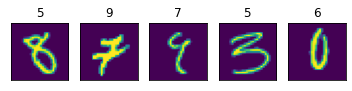

In [38]:
plot_example(X_test[error_mask], y_pred[error_mask])

## Questions:

Use the skorch library to investigate the impact on performance on the above neural network when changing the following parameters:

- Early stopping criterion
- Weight decay
- Momentum

Also, use the skorch library to carry out cross validation on the above neural network.